In [1]:
from crocoddyl import *
import pinocchio as pin
import numpy as np
from crocoddyl.diagnostic import displayTrajectory

In [2]:
# LOAD ROBOT
robot = loadHector()
robot.initViewer(loadModel=True)
robot.display(robot.q0)

robot.framesForwardKinematics(robot.q0)

rmodel = robot.model

In [30]:
def uavPlacementModel(targetPos, targetQuat, integrationStep, frameName):
    # ACTUATION MODEL
    distanceRotorCOG = 0.1525
    cf = 6.6e-5
    cm = 1e-6
    actModel = ActuationModelUAM(robot.model, distanceRotorCOG, cf, cm)

    # COST MODEL
    # Create a cost model per the running and terminal action model.
    runningCostModel = CostModelSum(rmodel, actModel.nu)
    terminalCostModel = CostModelSum(rmodel, actModel.nu)

    state = StatePinocchio(rmodel)
    SE3ref = pin.SE3()
    SE3ref.translation = targetPos.reshape(3,1)
    SE3ref.rotation = targetQuat.matrix()

    wBasePos  = [10]
    wBaseOri  = [1]
    wBaseVel  = [100]
    wBaseRate = [10]
    
    stateWeights   = np.array(wBasePos * 3 + wBaseOri * 3 + wBaseVel * robot.model.nv)
    controlWeights = np.array([10]*4)
    
    goalTrackingCost = CostModelFramePlacement(rmodel,
                                               frame=rmodel.getFrameId(frameName),
                                               ref=SE3ref,
                                               nu =actModel.nu)
    xRegCost = CostModelState(rmodel, 
                              state, 
                              ref=state.zero(), 
                              nu=actModel.nu,
                              activation=ActivationModelWeightedQuad(stateWeights))
    uRegCost = CostModelControl(rmodel, 
                                nu=robot.
                                model.nv-2,
                                activation = ActivationModelWeightedQuad(controlWeights))
    uLimCost = CostModelControl(rmodel, 
                                nu=robot.
                                model.nv-2,
                                activation = ActivationModelInequality(np.array([0.1, 0.1, 0.1, 0.1, -1, -1, -1, -1, -1, -1]), 
                                                                    np.array([5, 5, 5, 5, 1, 1, 1, 1, 1, 1])))

    # Then let's add the running and terminal cost functions
    runningCostModel.addCost(name="pos", weight=0.1, cost=goalTrackingCost)
    runningCostModel.addCost(name="regx", weight=1e-4, cost=xRegCost)
    runningCostModel.addCost(name="regu", weight=1e-6, cost=uRegCost)
    # runningCostModel.addCost(name="limu", weight=1e-3, cost=uLimCost)
    terminalCostModel.addCost(name="pos", weight=50, cost=goalTrackingCost)

    # DIFFERENTIAL ACTION MODEL
    runningDmodel  = DifferentialActionModelActuated(rmodel, actModel, runningCostModel)
    terminalDmodel = DifferentialActionModelActuated(rmodel, actModel, terminalCostModel)
    runningModel = IntegratedActionModelEuler(runningDmodel)
    runningModel.timeStep =  integrationStep  
    terminalModel = IntegratedActionModelEuler(terminalDmodel)
    terminalModel.timeStep =  integrationStep  
    
    return runningModel,terminalModel   

In [31]:
# DEFINING THE SHOOTING PROBLEM & SOLVING

# Defining the time duration for running action models and the terminal one
dt = 5e-2
T = 25


# DEFINE POSITION WAYPOINTS
target_pos = [np.array([0,0,1])]
target_pos += [np.array([0,1,1])]
quat = pin.Quaternion(1, 0, 0, 0)
quat.normalize()
target_quat = [quat]*2

# Plot goal frame
for i in range(0,len(target_pos)):
    robot.viewer.gui.addXYZaxis('world/wp%i' % i, [1., 0., 0., 1.], .03, 0.5)
    robot.viewer.gui.applyConfiguration('world/wp%i' % i, 
                                        target_pos[i].tolist() + [target_quat[i][0], target_quat[i][1], target_quat[i][2], target_quat[i][3]])
    
robot.viewer.gui.refresh()

In [32]:
models = []
for i in range(0,len(target_pos)):
    runningModel, terminalModel = uavPlacementModel(target_pos[i], target_quat[i], dt, 'base_link')
    models += [runningModel]*(T-1) + [terminalModel]

q0 = robot.q0
x0 = np.hstack([m2a(q0), np.zeros(robot.model.nv)])

problem = ShootingProblem(x0, models[:-1], models[-1])

# Creating the DDP solver for this OC problem, defining a logger
ddp = SolverFDDP(problem)
ddp.callback = [CallbackDDPVerbose()]
ddp.callback.append(CallbackDDPLogger())

# Solving it with the DDP algorithm
ddp.solve(maxiter=150)

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  3.68073e+00  1.25267e+00  1.56079e+02  1.00000e-09  1.00000e-09   1.0000     1
   1  1.00058e+00  1.66607e-01  5.80878e+00  1.00000e-09  1.00000e-09   1.0000     1
   2  8.01123e-01  6.25271e-03  3.87854e-01  1.00000e-09  1.00000e-09   1.0000     1
   3  7.95405e-01  6.31666e-05  9.12472e-03  1.00000e-09  1.00000e-09   1.0000     1
   4  7.94369e-01  1.35846e-05  1.46894e-03  1.00000e-09  1.00000e-09   1.0000     1
   5  7.94137e-01  1.45173e-06  3.08133e-04  1.00000e-09  1.00000e-09   1.0000     1
   6  7.94073e-01  3.43830e-07  8.33311e-05  1.00000e-09  1.00000e-09   1.0000     1
   7  7.94053e-01  8.34184e-08  2.54417e-05  1.00000e-09  1.00000e-09   1.0000     1
   8  7.94046e-01  2.26953e-08  8.44421e-06  1.00000e-09  1.00000e-09   1.0000     1
   9  7.94044e-01  6.57880e-09  2.98715e-06  1.00000e-09  1.00000e-09   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  10  7.94043e

([array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([ 0.00000000e+00, -1.01480409e-03,  1.19047887e-01,  8.52402554e-03,
          0.00000000e+00,  0.00000000e+00,  9.99963670e-01,  0.00000000e+00,
          0.00000000e+00,  2.38107307e+00,  3.40965151e-01,  0.00000000e+00,
          0.00000000e+00]),
  array([ 0.00000000e+00, -2.05452635e-03,  2.40532823e-01,  1.32991567e-02,
          0.00000000e+00,  0.00000000e+00,  9.99911562e-01,  0.00000000e+00,
          3.22313817e-02,  2.42958316e+00,  1.91016801e-01,  0.00000000e+00,
          0.00000000e+00]),
  array([ 6.20694709e-19, -3.17269406e-03,  3.47519141e-01,  1.69621642e-02,
          5.85347588e-18,  1.28108662e-17,  9.99856132e-01,  0.00000000e+00,
          4.23906229e-02,  2.13942809e+00,  1.46537158e-01,  2.40933816e-16,
          5.09276617e-16]),
  array([ 7.39828124e-19, -4.47708649e-03,  4.39445718e-01,  1.97573253e-02,
          5.97249921e-18,  1.27958640e-17,  9.99804805e-01, -1.91653387e-17,
      

In [28]:
displayTrajectory(robot, ddp.xs, dt)


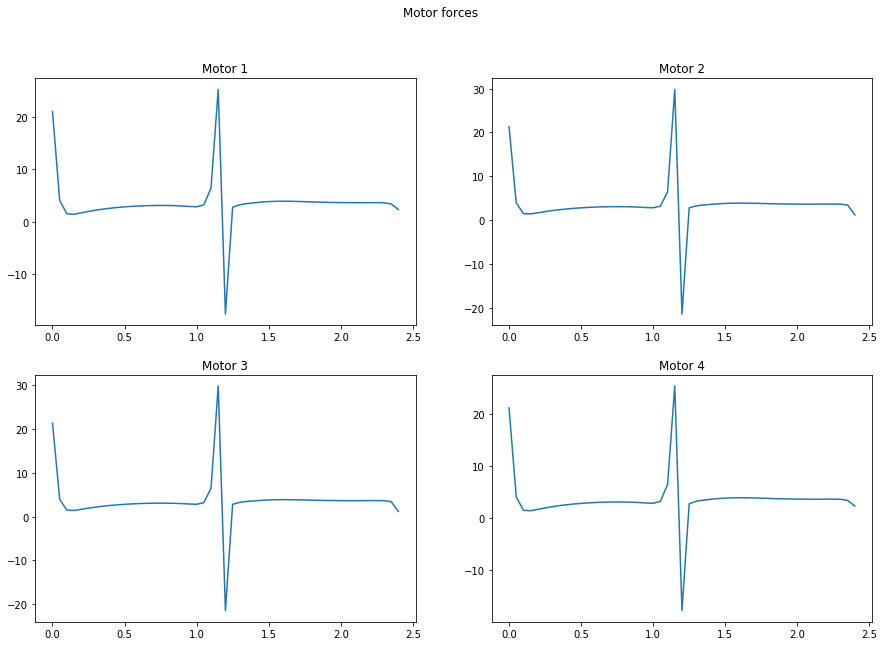

In [33]:
distanceRotorCOG = 0.1525
cf = 6.6e-5
cm = 1e-6
pltUAM = PlotUAM(ddp.xs, ddp.us, np.size(ddp.us,0), dt, distanceRotorCOG, cf, cm)

fig, axs = pltUAM.plotMotorForces()

AttributeError: 'list' object has no attribute 'set_title'

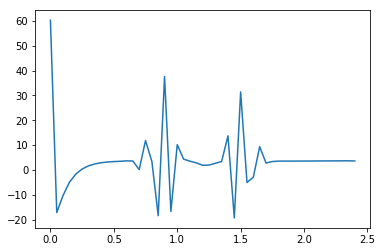

In [13]:
t = np.arange(0, 2*T*dt-dt, dt)
control = np.vstack(ddp.us)
fig = plt.figure()
axs = plt.plot(t, control[:,1])
axs.set_title('Moments')